In [1]:
### Importing all the neccessary packages ###
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy
from matplotlib.offsetbox import AnchoredText
import cartopy.feature as cfeature
import scipy.fft as sf
from scipy import signal
from scipy.stats import circmean
from scipy import optimize
import xarray.ufuncs as xu
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import seaborn as sns
from scipy.special import rel_entr
from scipy.stats import entropy
from scipy.special import kl_div

In [2]:
### Allows us to use dask to speed up some calculations ###
from dask.distributed import Client
client = Client()

distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-k4te7m4y', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-qwceb_f2', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-6bts8dwj', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-tnahsv54', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-2z5y7wyz', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-worker-space/worker-0e4cybw9', purging
distributed.diskutils - INFO - Found stale lock file and directory '/home/gbromley/code/ObsWetDrySeason/dask-wor

In [3]:

def curve(x, a0, a1, b1, a2, b2, a3, b3, a4, b4, a5, b5):
    output = (a0 +
    a1*np.cos(x/len(x)*2*np.pi) + b1*np.sin(x/len(x)*2*np.pi) + 
    a2*np.cos(x/len(x)*2*np.pi*2) + b2*np.sin(x/len(x)*2*np.pi*2)+ 
    a3*np.cos(x/len(x)*3*np.pi*2) + b3*np.sin(x/len(x)*3*np.pi*2)+
    a4*np.cos(x/len(x)*4*np.pi*2) + b4*np.sin(x/len(x)*4*np.pi*2)+
    a5*np.cos(x/len(x)*5*np.pi*2) + b5*np.sin(x/len(x)*5*np.pi*2))
    
    return output
    
def fit_curve(xdata, ydata):
    guess = [np.mean(ydata), 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    params, params_covariance = optimize.curve_fit(curve, xdata, ydata, guess)
    return params, params_covariance

def fourier5(tseries):
    mtot=len(tseries)
    time=np.arange(1,mtot+1,1.)
    params, _ = fit_curve(time,tseries)
    return curve(time,*params)
    
    
 

In [4]:
def curve_2harmonic(x, a0, a1, b1, a2, b2):
    output = (a0 +
    a1*np.cos(x/len(x)*2*np.pi) + b1*np.sin(x/len(x)*2*np.pi) + 
    a2*np.cos(x/len(x)*2*np.pi*2) + b2*np.sin(x/len(x)*2*np.pi*2))
    return output

def fit_curve2(xdata, ydata):
    guess = [np.mean(ydata), 0, 0, 0, 0]
    params, params_covariance = optimize.curve_fit(curve_2harmonic, xdata, ydata, guess)
    return params, params_covariance

def fourier2(tseries):
    mtot=len(tseries)
    time=np.arange(1,mtot+1,1.)
    params, _ = fit_curve2(time,tseries)
    return curve_2harmonic(time,*params)

In [5]:
data_dir = '/data/deluge/scratch/ERA5/2D/daily/precip/'

ds = xr.open_mfdataset(data_dir+'*.nc',parallel=True, chunks={'latitude': 25, 'longitude': 25, 'time': -1})


In [6]:
subset=ds.sel(latitude=slice(50,30), longitude=slice((360.0-125),(360.0-65.0)))


In [7]:

start = time.time()



ds_subset = subset.load()
end = time.time()
print(end - start)


125.16725969314575


In [8]:
def wrapperRelEntr(ds):
    print(ds)
    seasonality_ratio = xr.apply_ufunc(
    computeRelEntr,
    ds,
    input_core_dims=[["time"]],
    exclude_dims=set(["time"]),
    vectorize=True,
    dask = 'parallelized',
    #output_dtypes = 'datetime64[D]',
    #output_sizes={"data_jday": 71},
    )
    return seasonality_ratio
    

In [10]:
### Changing data to mm and removing leap days ###
ds_subset['precip'].values = ds_subset['precip'].values*1000.0
precip = ds_subset['precip']
precip = precip.sel(time=~((precip.time.dt.month == 2) & (precip.time.dt.day == 29)))

### Calculating the mean precipitation for each grid point
annual_mean_precip = precip.mean(dim='time')

### Calculating the mean annual cycle ###
annual_precip_cycle= precip.groupby('time.dayofyear').mean(dim='time')

annual_precip_cycle_var = precip.groupby('time.dayofyear').std(dim='time')

### Create Daily precip from hourly ###
##daily_precip = precip.resample(time='1D').sum()

### Create The annual daily precip anomalies ###
annual_means = precip.groupby('time.year').mean(dim='time')

anomalies = precip.groupby('time.year') - annual_means
#anomalies = anomalies_withleap.sel(time=~((anomalies_withleap.time.dt.month == 2) & (anomalies_withleap.time.dt.day == 29)))

climDailyMeanAnomaly = annual_precip_cycle - annual_mean_precip

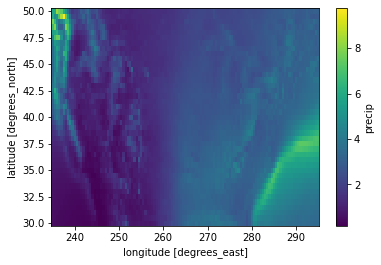

In [11]:
annual_mean_precip.plot()

In [12]:
smoothedPrecipClimatology= xr.apply_ufunc(
    fourier5,
    annual_precip_cycle.load(),
    input_core_dims=[["dayofyear"]],
    exclude_dims=set(["dayofyear"]),
    output_core_dims=[["dayofyear"]],
    vectorize=True,
    dask = 'parallelized',
    #output_dtypes = 'datetime64[D]',
    #output_sizes={"data_jday": 71},
)

In [13]:
def computeRelEntr(harmonic_cycle):
    p = harmonic_cycle
    sumHC = np.sum(p)
    p = p/sumHC
    q = np.zeros(len(harmonic_cycle))
    q[:] = (1/len(harmonic_cycle))
    
    return np.ma.masked_invalid(rel_entr(p,q)).sum()

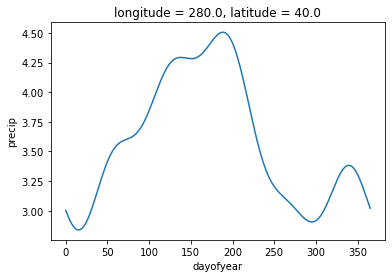

In [14]:
lat = 40
lon = 280

index = annual_precip_cycle.sel(latitude=lat,longitude=lon).dayofyear.values

vals = annual_precip_cycle.sel(latitude=lat,longitude=lon).values


smoothedPrecipClimatology.sel(latitude=lat, longitude=lon).plot()

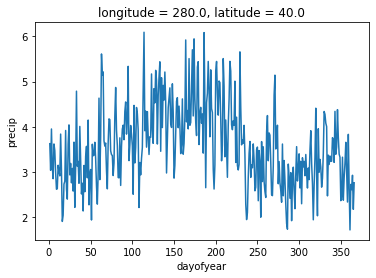

In [15]:
annual_precip_cycle.sel(latitude=lat,longitude=lon).plot()

In [16]:
maxima = signal.find_peaks(smoothedPrecipClimatology.sel(latitude=lat,longitude=lon).values, )[0]

In [17]:
minima = signal.find_peaks(-smoothedPrecipClimatology.sel(latitude=lat,longitude=lon).values)[0]

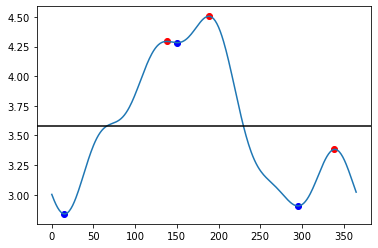

In [18]:
seasonVals = smoothedPrecipClimatology.sel(latitude=lat, longitude=lon).values

plt.plot(seasonVals)
plt.scatter(maxima,seasonVals[maxima], color='red')
plt.scatter(minima,seasonVals[minima],color='blue')
plt.axhline(annual_mean_precip.sel(latitude=lat, longitude=lon).values, color='black')

In [19]:
smoothedPrecipClim = seasonVals
meanPrecipClim = np.mean(smoothedPrecipClim)
shiftVal = np.argmin(smoothedPrecipClim)

smoothedPrecipClimShifted = np.roll(smoothedPrecipClim,-shiftVal)

maximaLocs = signal.find_peaks(smoothedPrecipClimShifted, height=meanPrecipClim, prominence=1)[0]
minimaLocs = signal.find_peaks(-smoothedPrecipClimShifted)[0]
maximaHeights = smoothedPrecipClimShifted[maximaLocs]
minimaHeights = smoothedPrecipClimShifted[minimaLocs]

### Analysis start is 50 days before minima###
### We shift to the minima so it's then missed by peak/valley finding ###

analysisStart = (0-50)

### Analysis end is 50 days after maxima ###
finalPeak = maximaLocs[-1]
analysisEnd = (finalPeak + 50)

### Need to sort to get largest peaks, last items are largest ###
idx   = np.argsort(maximaHeights)

maximaHeights = maximaHeights[idx]
maximaLocs = maximaLocs[idx]

### Sort the Mins ###
idn = np.argsort(minimaHeights)

minimaHeights = minimaHeights[idn]
minimaLocs = minimaLocs[idn]


### Find height of largest peak ###
peakOne = maximaHeights[-1]
#analysisStart = minimaLocs[0] - 50

### Find minima between two highest peaks ###
if len(maximaLocs)>=2:
    
    ### Finding the valley between peaks ###
    minSearch = ((maximaLocs[-1]<minimaLocs) & (minimaLocs<maximaLocs[-2])) | ((maximaLocs[-2]<minimaLocs) & (minimaLocs<maximaLocs[-1]))
    peakTwo = maximaHeights[-2]
    IDPMinimaLoc = minimaLocs[minSearch][0]
    IDPMinimaVal = minimaHeights[minSearch][0]
    IDPDistinct = IDPMinimaVal < meanPrecipClim

    peakDiff = np.max([[peakOne - IDPMinimaVal],[peakTwo-IDPMinimaVal]])
    
    lastPeak = np.max([maximaLocs[-2],maximaLocs[-1]])
    firstPeak = np.min([maximaLocs[-2],maximaLocs[-1]])
    IDPPeriod = (((IDPMinimaLoc - firstPeak)/2 +firstPeak), ((lastPeak - IDPMinimaLoc)/2+IDPMinimaLoc))








#wetWindow = (anal,IDPMinimaLoc)
#dryWindow = (IDPMinimaLoc,400)




if (len(maximaLocs) <= 1 or (peakDiff > 1.0 and IDPDistinct != True)):
    
    seasonClass = 1.0 ### Unimodal Dual Maximum
    #analysisStart = (minimaLocs[0])%366
    wetWindow = (analysisStart,analysisEnd)
    #dryWindow = (IDPMinimaLoc,analysisEnd)
    
    
elif (peakDiff > 1.0 and IDPDistinct):
    seasonClass = 2.0 ### Bimodal
    wetWindow = (analysisStart,IDPMinimaLoc)
    dryWindow = (IDPMinimaLoc,analysisEnd)
else:
    seasonClass = 0
    wetWindow = (analysisStart,IDPMinimaLoc)
    dryWindow = (IDPMinimaLoc,analysisEnd)




In [125]:
shiftVal

15

In [131]:
analysisEnd


223

In [132]:
-50%365

315

In [292]:
(finalPeak + 200) % 365 ### This is freaking circular math, finally understand what modulo does.

96

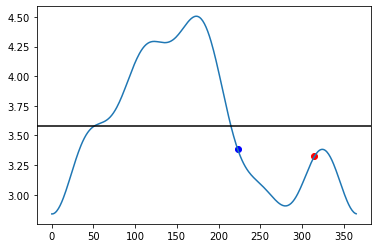

In [124]:
plt.plot(smoothedPrecipClimShifted)
plt.scatter(analysisStart%365,smoothedPrecipClimShifted[analysisStart], color='red')
plt.scatter(analysisEnd%365,smoothedPrecipClimShifted[analysisEnd],color='blue')
plt.axhline(annual_mean_precip.sel(latitude=lat, longitude=lon).values, color='black')

if IDPPeriod:
    plt.axvspan(IDPPeriod[0],IDPPeriod[1], color='yellow', alpha=0.5)

In [120]:
from scipy.ndimage import gaussian_filter1d
smoothed = gaussian_filter1d(precip.sel(latitude=lat, longitude=lon, time = '1980').values, sigma=2)

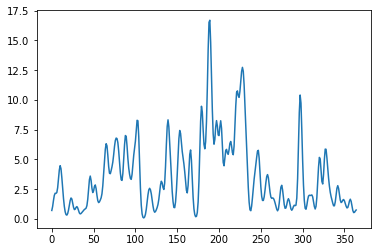

In [121]:
plt.plot(smoothed)

/home/gbromley/anaconda3/envs/obswetdryseason/lib/python3.7/site-packages/xarray/core/dataarray.py:3268: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  shifts=shifts, roll_coords=roll_coords, **shifts_kwargs


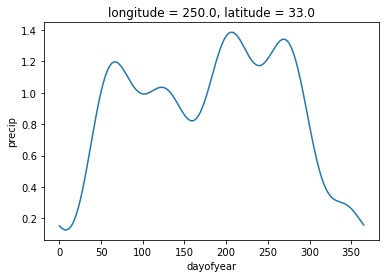

In [273]:
smoothedPrecipClimatology.sel(latitude=lat, longitude=lon).roll(dayofyear=-150).plot()

In [288]:
import itertools as it

SyntaxError: invalid syntax (2422593616.py, line 1)

In [145]:
def sorting(l1, l2):
    # l1 and l2 has to be numpy arrays
    idx = np.argsort(l1)
    return l1[idx], l2[idx]